In game Win Probability Modelling:
============================================
Part 3 : Modelling and Hyper Parameter Tuning
---------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, mean_squared_error, log_loss, accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from itertools import chain
import math
from xgboost import XGBClassifier
import xgboost as xgb # external package
from sklearn import svm

C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Setting display priorities, might cause security issues because of the raw html injection !
from IPython.core.display import display, HTML
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
display(HTML("<style>.container { width:80% !important; }</style>")) # uncomment for security issues
np.set_printoptions(precision=4)
pd.set_option('display.max_columns',50)

Cross validation
---------------

The data points of the same game are highly correlated and hence while evaluating the model we have to make sure that the test data set doesnt contain any data points from the games used in the train data set

In [3]:
# A custom cross validation generator that yields the game_if of train data set
# k is number of folds and split is the train : test data split 
def crossval_generator(column, k=5, split=0.75, random = 305):
    total_unique = np.unique(column).shape[0]
    np.random.seed(random)
    for i in range(k):
        yield np.random.choice(np.unique(column), size = int(total_unique*split), replace=False)
        

In [4]:
# Cross validation based on game id. The game's that are used in training are not used in testing
#  a method for quick check of performance without hyper parameter tuning . Takes an estimator as model parameter
def model_trainer(dataframe, model, k=5):
    j = 0
    mse, accuracy, logloss = np.empty([1,k]), np.empty([1,k]), np.empty([1,k])
    for i in crossval_generator(dataframe['game_id'], k):
        train_data = dataframe[dataframe['game_id'].isin(i)]
        test_data = dataframe[~dataframe['game_id'].isin(i)]

        train_data = train_data.drop(labels=['game_id'], axis=1)
        test_data =test_data.drop(labels=['game_id'], axis=1)

        train_X = train_data.loc[:,train_data.columns != 'home_result'].values
        train_y = train_data['home_result'].values
        test_X = test_data.loc[:,train_data.columns != 'home_result'].values
        test_y = test_data['home_result'].values

        print("Training the {} fold. Train data shape {}, Test data shape{}".format(j+1,(train_X.shape, train_y.shape), (test_X.shape, test_y.shape)))

        m = model()
        m.fit(train_X.tolist(), train_y.tolist())

        predicted = m.predict(test_X)
        predicted_proba = m.predict_proba(test_X)

        accuracy.itemset(j, accuracy_score(test_y.tolist(), predicted))
        true = pd.get_dummies(test_y).values
        mse.itemset(j, mean_squared_error(true, predicted_proba))
        logloss.itemset(j, log_loss(test_y.tolist(), predicted_proba))
        j += 1

    print("Final Result:")
    print("MSE : {} +- {}".format(mse.mean(), mse.std()))
    print("Accuracy : {} +- {}".format(accuracy.mean(), accuracy.std()))
    print("Logloss : {} +- {}".format(logloss.mean(), logloss.std()))
    return m

In [245]:
model_trainer(data_model, LogisticRegression)

Training the 1 fold. Train data shape ((220945, 27), (220945,)), Test data shape((73421, 27), (73421,))
Training the 2 fold. Train data shape ((221313, 27), (221313,)), Test data shape((73053, 27), (73053,))
Training the 3 fold. Train data shape ((220165, 27), (220165,)), Test data shape((74201, 27), (74201,))
Training the 4 fold. Train data shape ((220984, 27), (220984,)), Test data shape((73382, 27), (73382,))
Training the 5 fold. Train data shape ((221868, 27), (221868,)), Test data shape((72498, 27), (72498,))
Final Result:
MSE : 0.08860649648486932 +- 0.0019859104690839436
Accuracy : 0.8745861202609868 +- 0.003319067378619056
Logloss : 0.28107143118251376 +- 0.007380520381957095


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [5]:
data_clean = pd.read_csv("data_clean.csv", index_col = None)
data_clean.drop(labels=['Unnamed: 0', 'sequence_id'], axis=1, inplace=True)
data_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
data_clean.fillna(value=0, inplace=True)

data_model = data_model = data_clean.drop(labels=['period', 'play_clock', 'home_description', 'away_description', 'score', 'player1_id', 'player1_name', 'player1_team', 'player2_id', 'player2_name', 'player2_team', 'player3_id', 'player3_name','player3_team', 'event_type', 'home', 'away', 'event_description'], axis=1)

In [6]:
data_model.columns

Index(['game_id', 'remaining_time', 'score_difference',
       'score_diff_percentile', 'home_result', 'in_violations', 'in_rebound',
       'in_hfouls', 'in_hshoot_fouls', 'in_afouls', 'in_ashoot_fouls',
       'in_turnover', 'in_shot_accuracy', 'in_ft_accuracy', 'in_momentum',
       'total_win_ratio', 'home_away_win_ratio', 'nth_game_season', 'pre_PACE',
       'pre_AST', 'pre_TO', 'pre_ORR', 'pre_DRR', 'pre_EFF_FG', 'pre_TS',
       'pre_OFF_EFF', 'pre_DEF_EFF', 'home_rank', 'away_rank'],
      dtype='object')

We will be using Logistic regression, RandomForest, SVM and XGB Classifier for our in game win predictability. LogisticRegression has good interpretability  
and low efficiency whereas XGB falls on the other end of the spectrum. These four models should give a good sense of the data.  

All fields except game_id and home_result are normalized.
Hyper parameter tuning is done using Randomized Search CV that draws combinations of parameters in a uniformly distributed way and hence limits the number of possible combinations making it suitable for running in a personal laptop.

The data points from a single game is highly correlated. Each event doesnt drastically change a data point's signature.
Hence I split the data points into buckets of 24 seconds from 12th minute to the 2nd minute and for the last two minutes grouping them in 12 seconds buckets.
All games had more data points in the last few minutes and hence this variable bucket size is used to keep the data stratified.

Randomly out of this buckets, only one data point is chosen and hence each game will have one data point in each bucket (~36 data pts per game). This reduces correlation 
as well as overfitting in the modelling and speeds up hyper parameter tuning without any loss in efficiency. As mentioned before games used in training set are not used in the test set.

In [7]:
bins = list(range(0, 120, 12)) + list(range(120, 721, 24))
binned_df = pd.DataFrame(pd.cut(data_model['remaining_time'], bins, include_lowest=True))
binned_df.reset_index(inplace=True)

data_model['time_bracket'] = pd.Series(dtype='object')
data_model.time_bracket = binned_df.remaining_time

strat_sample = data_model.groupby(['game_id', 'time_bracket']).apply(lambda x: x.sample(min(len(x), 1)))
strat_sample.reset_index(drop=True, inplace=True)

strat_sample.drop(labels=['time_bracket'], axis=1, inplace=True)
data_model.drop(labels=['time_bracket'], axis=1, inplace=True)
strat_sample = strat_sample.sample(n=strat_sample.shape[0])
bkp_strat = strat_sample.copy()

print("Train data size {}".format(strat_sample.shape))

Train data size (78661, 29)


In [15]:
rf_logloss, xgb_logloss, lr_logloss = np.empty([1,5]), np.empty([1,5]), np.empty([1,5])
j = 0

for i in crossval_generator(strat_sample['game_id'], k=5):
    train_index = i
    train_data = strat_sample[strat_sample['game_id'].isin(train_index)]
    test_data = strat_sample[~strat_sample['game_id'].isin(train_index)]

    train_labels = train_data['home_result']
    test_labels = test_data['home_result']
    train_data.drop(labels=['home_result','game_id'], axis=1, inplace=True)
    test_data.drop(labels=['home_result','game_id'], axis=1, inplace=True)
    
    print("Train data shape{}".format(train_data.shape))
    print("Test data shape{}".format(test_data.shape))
    
    rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=3, oob_score=False, random_state=1234,
            verbose=0, warm_start=False)
    rf.fit(train_data.values.tolist(), train_labels.values)
    
    rf_logloss.itemset(j, log_loss(test_labels.values, rf.predict_proba(test_data.values.tolist())))
    
    lr = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=3,
          penalty='l2', random_state=1234, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
    lr.fit(train_data.values.tolist(), train_labels.values)
    
    lr_logloss.itemset(j, log_loss(test_labels.values, lr.predict_proba(test_data.values.tolist())))
    
    dtrain = xgb.DMatrix(train_data.values.tolist(), label=train_labels.values, feature_names=train_data.columns)
    dtest = xgb.DMatrix(test_data.values.tolist(), label=test_labels.values, feature_names=test_data.columns)
    evallist = [(dtest,'eval'),(dtrain,'train')]

    xgbmodel = xgb.train(param, dtrain, 70, evallist, early_stopping_rounds=5)
    
    xgb_logloss.itemset(j, log_loss(test_labels, xgbmodel.predict(dtest)))
    
    j += 1


C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train data shape(58964, 27)
Test data shape(19697, 27)
[0]	eval-logloss:0.631637	train-logloss:0.631695
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 5 rounds.
[1]	eval-logloss:0.581017	train-logloss:0.580975
[2]	eval-logloss:0.539068	train-logloss:0.539063
[3]	eval-logloss:0.504088	train-logloss:0.504252
[4]	eval-logloss:0.474272	train-logloss:0.474599
[5]	eval-logloss:0.448663	train-logloss:0.449234
[6]	eval-logloss:0.44434	train-logloss:0.44195
[7]	eval-logloss:0.422458	train-logloss:0.420395
[8]	eval-logloss:0.403813	train-logloss:0.402317
[9]	eval-logloss:0.388195	train-logloss:0.386691
[10]	eval-logloss:0.373833	train-logloss:0.372352
[11]	eval-logloss:0.361191	train-logloss:0.360139
[12]	eval-logloss:0.359265	train-logloss:0.356752
[13]	eval-logloss:0.358016	train-logloss:0.352719
[14]	eval-logloss:0.347615	train-logloss:0.342882
[15]	eval-logloss:0.3379	train-logloss:0.333813
[16]	eval

C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0]	eval-logloss:0.632261	train-logloss:0.631561
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 5 rounds.
[1]	eval-logloss:0.620215	train-logloss:0.615969
[2]	eval-logloss:0.571938	train-logloss:0.566973
[3]	eval-logloss:0.531466	train-logloss:0.525979
[4]	eval-logloss:0.498295	train-logloss:0.492004
[5]	eval-logloss:0.469448	train-logloss:0.462462
[6]	eval-logloss:0.445063	train-logloss:0.437159
[7]	eval-logloss:0.423889	train-logloss:0.415544
[8]	eval-logloss:0.405807	train-logloss:0.396883
[9]	eval-logloss:0.390319	train-logloss:0.380765
[10]	eval-logloss:0.376162	train-logloss:0.366006
[11]	eval-logloss:0.364389	train-logloss:0.353715
[12]	eval-logloss:0.35392	train-logloss:0.342359
[13]	eval-logloss:0.344847	train-logloss:0.332473
[14]	eval-logloss:0.336964	train-logloss:0.323487
[15]	eval-logloss:0.330385	train-logloss:0.315847
[16]	eval-logloss:0.324347	train-logloss:0.309179
[17]	eval-l

C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Test data shape(19664, 27)
[0]	eval-logloss:0.631786	train-logloss:0.631543
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 5 rounds.
[1]	eval-logloss:0.582059	train-logloss:0.581011
[2]	eval-logloss:0.540215	train-logloss:0.538672
[3]	eval-logloss:0.505195	train-logloss:0.503399
[4]	eval-logloss:0.475751	train-logloss:0.473501
[5]	eval-logloss:0.470488	train-logloss:0.465977
[6]	eval-logloss:0.445998	train-logloss:0.441246
[7]	eval-logloss:0.425006	train-logloss:0.419987
[8]	eval-logloss:0.406802	train-logloss:0.401693
[9]	eval-logloss:0.390611	train-logloss:0.385533
[10]	eval-logloss:0.387759	train-logloss:0.381162
[11]	eval-logloss:0.373943	train-logloss:0.367527
[12]	eval-logloss:0.362688	train-logloss:0.356157
[13]	eval-logloss:0.351319	train-logloss:0.344751
[14]	eval-logloss:0.342613	train-logloss:0.336178
[15]	eval-logloss:0.333529	train-logloss:0.327062
[16]	eval-logloss:0.3321	train-l

C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0]	eval-logloss:0.630649	train-logloss:0.631736
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 5 rounds.
[1]	eval-logloss:0.579391	train-logloss:0.580938
[2]	eval-logloss:0.537298	train-logloss:0.539206
[3]	eval-logloss:0.501354	train-logloss:0.50356
[4]	eval-logloss:0.493451	train-logloss:0.492867
[5]	eval-logloss:0.464203	train-logloss:0.464142
[6]	eval-logloss:0.439693	train-logloss:0.440052
[7]	eval-logloss:0.436084	train-logloss:0.434983
[8]	eval-logloss:0.415422	train-logloss:0.414743
[9]	eval-logloss:0.397759	train-logloss:0.397538
[10]	eval-logloss:0.381257	train-logloss:0.381403
[11]	eval-logloss:0.36782	train-logloss:0.368103
[12]	eval-logloss:0.355399	train-logloss:0.356081
[13]	eval-logloss:0.34494	train-logloss:0.345912
[14]	eval-logloss:0.335558	train-logloss:0.33666
[15]	eval-logloss:0.327626	train-logloss:0.328915
[16]	eval-logloss:0.320193	train-logloss:0.321721
[17]	eval-logl

C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train data shape(58980, 27)
Test data shape(19681, 27)
[0]	eval-logloss:0.630921	train-logloss:0.632199
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 5 rounds.
[1]	eval-logloss:0.579933	train-logloss:0.581764
[2]	eval-logloss:0.536895	train-logloss:0.539737
[3]	eval-logloss:0.528196	train-logloss:0.529082
[4]	eval-logloss:0.49362	train-logloss:0.495325
[5]	eval-logloss:0.487227	train-logloss:0.485902
[6]	eval-logloss:0.45883	train-logloss:0.458038
[7]	eval-logloss:0.454683	train-logloss:0.451174
[8]	eval-logloss:0.430915	train-logloss:0.428343
[9]	eval-logloss:0.427407	train-logloss:0.423228
[10]	eval-logloss:0.407432	train-logloss:0.404063
[11]	eval-logloss:0.390067	train-logloss:0.387302
[12]	eval-logloss:0.375059	train-logloss:0.372883
[13]	eval-logloss:0.361833	train-logloss:0.360175
[14]	eval-logloss:0.350267	train-logloss:0.348857
[15]	eval-logloss:0.34915	train-logloss:0.346323
[16]	eva

In [16]:
print("Logloss RF: {} +- {}".format(rf_logloss.mean(), rf_logloss.std()))
print("Logloss LR: {} +- {}".format(lr_logloss.mean(), lr_logloss.std()))
print("Logloss XGB: {} +- {}".format(xgb_logloss.mean(), xgb_logloss.std()))

Logloss RF: 0.3270193218207386 +- 0.00622468304235517
Logloss LR: 0.2712209787379241 +- 0.009572511361042252
Logloss XGB: 0.2702710812283954 +- 0.008379325202836362


| Model | Logloss for 5 fold cv  |
|------|------|
|   Random Forest  | 0.3270 +- 0.0062 |
|   Logistic Regression | 0.2712 +- 0.009 |
|   Extreme Gradient Boosting | 0.2702 +- 0.008 |

In [48]:
# best estimator after hyper parameter tuning
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=3, oob_score=False, random_state=1234,
            verbose=0, warm_start=False)

rf.fit(train_data.values.tolist(), train_labels.values)
print("Accuracy {}".format(accuracy_score(rf.predict(test_data.values.tolist()), test_labels.values)))
print("Logloss {}".format(log_loss(test_labels.values, rf.predict_proba(test_data))))

Accuracy 0.8804430669173314
Logloss 0.2831144101387641


In [274]:
rf.feature_importances_

array([ 0.00721208,  0.34600413,  0.38741034,  0.00177342,  0.00433529,
        0.0017697 ,  0.00209445,  0.00250986,  0.00259296,  0.00261871,
        0.00767018,  0.00303043,  0.00338006,  0.02109343,  0.00283098,
        0.01449388,  0.01300656,  0.02161415,  0.01468987,  0.0155721 ,
        0.01471476,  0.01447272,  0.02271873,  0.0275406 ,  0.03417058,
        0.00549354,  0.00518648])

In [47]:
# best estimator after hyper parameter tuning
lr = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1234, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

lr.fit(train_data.values.tolist(), train_labels.values)
print("Accuracy {}".format(accuracy_score(lr.predict(test_data.values.tolist()), test_labels.values)))
print("Logloss {}".format(log_loss(test_labels.values, lr.predict_proba(test_data))))


Accuracy 0.8850160052842844
Logloss 0.26068563252171356


SVM Hyper parameter tuning:

In [276]:
svm_model = svm.SVC(C=1, probability=True)
param_list = {'kernel':[ 'sigmoid'],'gamma':[0.1, 0.001, 0.01, 0.0001], 'C':[0.1,0.001, 0.01], 'max_iter':[10, 50, 100]}
svm_grid = RandomizedSearchCV(svm_model, param_list, scoring='neg_log_loss',cv=10, n_jobs=3, n_iter=20)
svm_grid.fit(train_data, train_labels)

C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=3,
          param_distributions={'kernel': ['sigmoid'], 'max_iter': [10, 50, 100], 'C': [0.1, 0.001, 0.01], 'gamma': [0.1, 0.001, 0.01, 0.0001]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_log_loss', verbose=0)

In [124]:
# best negative log loss and estimator
svm_grid.best_score_, svm_grid.best_estimator_

(-0.45892223656621794, SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=0.001, kernel='sigmoid',
   max_iter=100, probability=True, random_state=None, shrinking=True,
   tol=0.001, verbose=False))

In [46]:
# Training on the best estimator
svm_model = svm.SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=0.001, kernel='sigmoid',
   max_iter=50, probability=True, random_state=None, shrinking=True,
   tol=0.001, verbose=False)

svm_model.fit(train_data, train_labels)
print("Accuracy {}".format(accuracy_score(svm_model.predict(test_data.values.tolist()), test_labels.values)))
print("Logloss {}".format(log_loss(test_labels.values, svm_model.predict_proba(test_data))))

C:\Users\Adiamaan Keerthi\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Accuracy 0.6207509781007062
Logloss 0.6589971656276973


In [43]:
# XGB estimator after hyper parameter tuning
dtrain = xgb.DMatrix(train_data.values.tolist(), label=train_labels.values, feature_names=train_data.columns)
dtest = xgb.DMatrix(test_data.values.tolist(), label=test_labels.values, feature_names=test_data.columns)
evallist = [(dtest,'eval'),(dtrain,'train')]

param = {'max_depth':8, 'eta':0.1,'silent':1,'objective':'binary:logistic','nthread':4,'eval_metric':['logloss'],'gamma':100,'min_child_weight':100,'subsample':0.5,'colsample_bytree':0.7}
xgbmodel = xgb.train(param, dtrain, 100, evallist, early_stopping_rounds=5)
xgb_predict = xgbmodel.predict(dtest)

[0]	eval-logloss:0.630921	train-logloss:0.632199
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 5 rounds.
[1]	eval-logloss:0.579933	train-logloss:0.581764
[2]	eval-logloss:0.536895	train-logloss:0.539737
[3]	eval-logloss:0.528196	train-logloss:0.529082
[4]	eval-logloss:0.49362	train-logloss:0.495325
[5]	eval-logloss:0.487227	train-logloss:0.485902
[6]	eval-logloss:0.45883	train-logloss:0.458038
[7]	eval-logloss:0.454683	train-logloss:0.451174
[8]	eval-logloss:0.430915	train-logloss:0.428343
[9]	eval-logloss:0.427407	train-logloss:0.423228
[10]	eval-logloss:0.407432	train-logloss:0.404063
[11]	eval-logloss:0.390067	train-logloss:0.387302
[12]	eval-logloss:0.375059	train-logloss:0.372883
[13]	eval-logloss:0.361833	train-logloss:0.360175
[14]	eval-logloss:0.350267	train-logloss:0.348857
[15]	eval-logloss:0.34915	train-logloss:0.346323
[16]	eval-logloss:0.33829	train-logloss:0.33588
[17]	eval-loglo

In [44]:
print("XGB log loss = {}".format(log_loss(test_labels, xgb_predict)))

XGB log loss = 0.2603747006067536


In [49]:
time = bkp_strat[~bkp_strat['game_id'].isin(train_index)].remaining_time
result = pd.concat([pd.Series(time.values),pd.Series(test_labels.values), pd.Series(xgbmodel.predict(dtest)), pd.Series(lr.predict_proba(test_data)[:,1]), pd.Series(rf.predict_proba(test_data)[:,1]), pd.Series(svm_model.predict_proba(test_data)[:,1])], axis=1)
result.reset_index(drop=True, inplace=True)
result.columns = ['remaining_time', 'result', 'xgb', 'lr','rf','svm']

In [50]:
bins = list(range(0, 120, 12)) + list(range(120, 721, 24))
result['time_bracket'] = pd.Series(dtype='object')
result['time_bracket'] = pd.cut(result['remaining_time'], bins, include_lowest=True)
result.groupby('time_bracket').size()

time_bracket
(-0.001, 12.0]    595
(12.0, 24.0]      463
(24.0, 36.0]      496
(36.0, 48.0]      494
(48.0, 60.0]      464
(60.0, 72.0]      468
(72.0, 84.0]      473
(84.0, 96.0]      489
(96.0, 108.0]     485
(108.0, 120.0]    463
(120.0, 144.0]    589
(144.0, 168.0]    588
(168.0, 192.0]    590
(192.0, 216.0]    593
(216.0, 240.0]    592
(240.0, 264.0]    588
(264.0, 288.0]    591
(288.0, 312.0]    588
(312.0, 336.0]    589
(336.0, 360.0]    591
(360.0, 384.0]    589
(384.0, 408.0]    591
(408.0, 432.0]    593
(432.0, 456.0]    591
(456.0, 480.0]    594
(480.0, 504.0]    590
(504.0, 528.0]    595
(528.0, 552.0]    594
(552.0, 576.0]    594
(576.0, 600.0]    595
(600.0, 624.0]    591
(624.0, 648.0]    593
(648.0, 672.0]    593
(672.0, 696.0]    594
(696.0, 720.0]    595
dtype: int64

In [51]:
def logloss(true_label, predicted, eps=1e-15):
  p = np.clip(predicted, eps, 1 - eps)
  if true_label == 1:
    return -math.log(p)
  else:
    return -math.log(1 - p)

result['xgb_logloss'] = pd.Series(dtype='float32')
result['lr_logloss'] = pd.Series(dtype='float32')
result['rf_logloss'] = pd.Series(dtype='float32')
#result['svm_logloss'] = pd.Series(dtype='float32')

In [52]:
for i in range(result.shape[0]):
    result.xgb_logloss.set_value(i, logloss(result['result'][i], result['xgb'][i]))
    result.lr_logloss.set_value(i, logloss(result['result'][i], result['lr'][i]))
    result.rf_logloss.set_value(i, logloss(result['result'][i], result['rf'][i]))
    #result.svm_logloss.set_value(i, logloss(result['result'][i], result['svm'][i]))

In [53]:
visual = result.groupby('time_bracket')['xgb_logloss','lr_logloss','rf_logloss'].mean()

SVM has a very poor performance. The real competition is between RF and XGB.
XGB has a better over all performance as well as better performance near the end of the game which is what we need

In [205]:
len(list(range(0, 120, 12)) + list(range(120, 721, 24)))

36

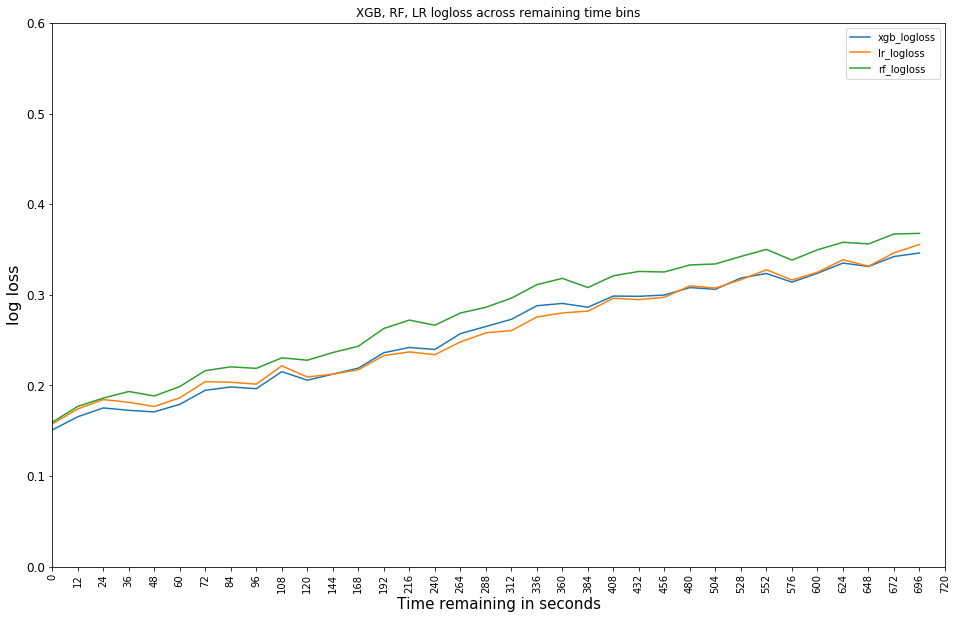

In [56]:
fig = plt.figure(figsize=(16,10))
ax = fig.gca()
visual.plot(ax=ax,title="XGB, RF, LR logloss across remaining time bins", fontsize=16)
plt.ylabel('log loss', fontsize=16)
plt.ylim(0, 0.60)
plt.yticks(fontsize=12)
plt.xlabel('Time remaining in seconds', fontsize=15)
plt.xticks(range(36), list(range(0, 120, 12)) + list(range(120, 721, 24)), rotation=90, fontsize=10)
plt.show()
ax.set_facecolor('red')
ax.set_facecolor((1, 0, 0))

XGB seems to be the best model. We will use it to train the entire data set and dump the model to the disk to use it in the file 

In [12]:
entire_data  = strat_sample.drop(labels=['game_id', 'home_result'], axis=1)

In [17]:
param = {'max_depth':8, 'eta':0.1,'silent':1,'objective':'binary:logistic','nthread':4,'eval_metric':['logloss'],'gamma':100,'min_child_weight':100,'subsample':0.5,'colsample_bytree':0.7}
dtrain = xgb.DMatrix(entire_data.values.tolist(), label=strat_sample['home_result'].values, feature_names=entire_data.columns)
xgbmodel = xgb.train(param, dtrain, 60)

In [38]:
entire_data.head()

,remaining_time,score_difference,score_diff_percentile,in_violations,in_rebound,in_hfouls,in_hshoot_fouls,in_afouls,in_ashoot_fouls,in_turnover,in_shot_accuracy,in_ft_accuracy,in_momentum,total_win_ratio,home_away_win_ratio,nth_game_season,pre_PACE,pre_AST,pre_TO,pre_ORR,pre_DRR,pre_EFF_FG,pre_TS,pre_OFF_EFF,pre_DEF_EFF,home_rank,away_rank
35500,422,-6,-0.031250,0.0,1.0,2.0,1.0,0.0,1.0,1.0,0.238636,0.00,-0.142857,0.492958,0.0,0.872358,-1.0,1.8,0.3,-1.7,5.7,3.3,3.1,1.7,2.0,182.399994,106.500000
41729,75,-21,-0.120000,0.0,3.0,3.0,2.0,1.0,1.0,2.0,0.077381,-0.75,0.000000,1.000000,0.0,0.026016,-3.2,2.0,0.1,1.8,0.3,3.0,2.8,2.7,5.2,0.000000,305.333344
6037,611,10,0.070423,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.00,0.052632,0.500000,0.0,0.148780,4.6,-1.4,-0.9,4.4,2.5,4.5,2.2,2.4,7.4,174.666672,261.000000
23651,228,-2,-0.010204,0.0,-1.0,2.0,1.0,1.0,2.0,0.0,0.030952,0.50,0.000000,0.511111,1.0,0.582114,-2.5,-1.8,1.5,-1.6,1.0,-0.5,0.5,0.1,-2.1,141.333328,147.199997
56863,34,-15,-0.082873,0.0,-2.0,2.0,0.0,0.0,2.0,-3.0,0.212121,0.75,0.000000,0.593750,0.0,0.397561,-6.9,-1.1,-0.7,5.3,3.7,5.5,1.4,2.1,6.5,154.000000,267.666656


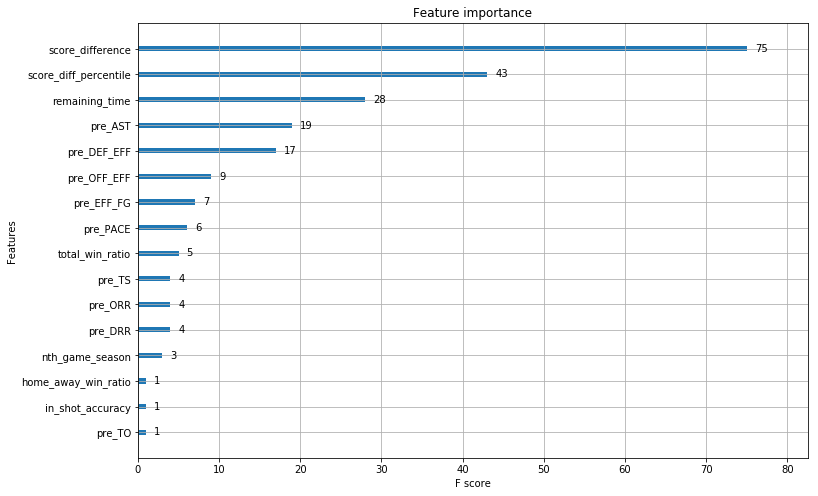

In [24]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
xgb.plot_importance(xgbmodel, ax=ax)
plt.show()

In [23]:
# Saving the xgbmodel to reuse
xgbmodel.save_model('xgb.model')
xgbmodel.dump_model('dump.raw.txt','featmap.txt')

In [39]:
entire_data.columns

Index(['remaining_time', 'score_difference', 'score_diff_percentile',
       'in_violations', 'in_rebound', 'in_hfouls', 'in_hshoot_fouls',
       'in_afouls', 'in_ashoot_fouls', 'in_turnover', 'in_shot_accuracy',
       'in_ft_accuracy', 'in_momentum', 'total_win_ratio',
       'home_away_win_ratio', 'nth_game_season', 'pre_PACE', 'pre_AST',
       'pre_TO', 'pre_ORR', 'pre_DRR', 'pre_EFF_FG', 'pre_TS', 'pre_OFF_EFF',
       'pre_DEF_EFF', 'home_rank', 'away_rank'],
      dtype='object')

In [34]:
filename = "strat_sample.csv"
strat_sample.to_csv(filename)
